In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import analysis.motif_util as motif_util
import feature.util as feature_util
import feature.simulated_dataset as simulated_dataset
import feature.experimental_dataset as experimental_dataset
import train.train_model as train_model
import os
import json
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tempfile
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define paths and constants

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
datasets = [
    "SPI1", "TAL/GATA", "E2F6", "JUND/TEAD", "REST", "SPI1/CTCF",
    "CTCF (HepG2)", "FOXA1 (HepG2)", "DNase (HepG2)", "DNase (K562)"
]

In [6]:
datasets_sanit = {
    dataset_key : dataset_key.replace("/", "_").replace(" ", "").replace("(", "_").replace(")", "").lower()
    for dataset_key in datasets
}

In [7]:
mechint_model_paths = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/mechint_net/2/last_ckpt.pth"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/mechint_net/2/last_ckpt.pth"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/mechint_net/2/last_ckpt.pth"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/mechint_net/2/last_ckpt.pth"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/mechint_net/2/last_ckpt.pth"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/mechint_net/3/last_ckpt.pth"),
    "CTCF (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/mechint_net/1/last_ckpt.pth"),
    "FOXA1 (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/mechint_net/3/last_ckpt.pth"),
    "DNase (HepG2)": os.path.join(base_path, "models/trained_models/experimental/dnase_hepg2/mechint_net/3/last_ckpt.pth"),
    "DNase (HL-60)": os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/mechint_net/3/last_ckpt.pth"),
    "DNase (K562)": os.path.join(base_path, "models/trained_models/experimental/dnase_k562/mechint_net/1/last_ckpt.pth")
}

In [8]:
modisco_results_paths = {
    "SPI1": os.path.join(base_path, "results/impscore_modisco/simulated/spi1_exp_single/standard_cnn/shap_modisco_results.h5"),
    "TAL/GATA": os.path.join(base_path, "results/impscore_modisco/simulated/tal_gata_exp_mix/standard_cnn/shap_modisco_results.h5"),
    "E2F6": os.path.join(base_path, "results/impscore_modisco/simulated/e2f6_max_exp_coop/standard_cnn/shap_modisco_results.h5"),
    "JUND/TEAD": os.path.join(base_path, "results/impscore_modisco/simulated/jund_tead_exp_hard_spacing/standard_cnn/shap_modisco_results.h5"),
    "REST": os.path.join(base_path, "results/impscore_modisco/simulated/rest_exp_both/standard_cnn/shap_modisco_results.h5"),
    "SPI1/CTCF": os.path.join(base_path, "results/impscore_modisco/simulated/spi1_ctcf_exp_repress/standard_cnn/shap_modisco_results.h5"),
    "CTCF (HepG2)": os.path.join(base_path, "results/impscore_modisco/experimental/chipseq_ctcf_hepg2/standard_cnn/shap_modisco_results.h5"),
    "FOXA1 (HepG2)": os.path.join(base_path, "results/impscore_modisco/experimental/chipseq_foxa1_hepg2/standard_cnn/shap_modisco_results.h5"),
    "DNase (HepG2)": os.path.join(base_path, "results/impscore_modisco/experimental/dnase_hepg2/standard_cnn/shap_modisco_results.h5"),
    "DNase (HL-60)": os.path.join(base_path, "results/impscore_modisco/experimental/dnase_hl60/standard_cnn/shap_modisco_results.h5"),
    "DNase (K562)": os.path.join(base_path, "results/impscore_modisco/experimental/dnase_k562/standard_cnn/shap_modisco_results.h5")
}

In [9]:
sim_motif_config_paths = {
    "SPI1": [os.path.join(base_path, "data/simulations/configs/spi1_exp_single_config.json")],
    "TAL/GATA": [os.path.join(base_path, "data/simulations/configs/tal_gata_exp_mix_config.json")],
    "E2F6": [os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_config.json"), os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_neg_config.json")],
    "JUND/TEAD": [os.path.join(base_path, "data/simulations/configs/jund_tead_exp_hard_spacing_config.json")],
    "REST": [os.path.join(base_path, "data/simulations/configs/rest_exp_both_config.json"), os.path.join(base_path, "data/simulations/configs/rest_exp_both_neg_config.json")],
    "SPI1/CTCF": [os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_config.json"), os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_neg_config.json")],
}

In [10]:
exp_peak_bed_paths = {
    "CTCF (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF664UGR_idrpeaks.bed.gz"),
    "FOXA1 (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF081USG_idrpeaks.bed.gz"),
    "DNase (HepG2)": os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF897NME_peaks.bed.gz"),
    "DNase (HL-60)": os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF773SFA_peaks.bed.gz"),
    "DNase (K562)": os.path.join(base_path, "data/encode/dnase/ENCSR000EKS_K562/ENCFF274YGF_peaks.bed.gz")
}

In [11]:
sim_datasets = [dataset_key for dataset_key in datasets if dataset_key in sim_motif_config_paths]
exp_datasets = [dataset_key for dataset_key in datasets if dataset_key in exp_peak_bed_paths]
assert sorted(datasets) == sorted(sim_datasets + exp_datasets)

In [12]:
exp_footprint_paths = {
    "HepG2": os.path.join(base_path, "data/databases/footprints/merged_beds/HepG2.bed"),
    "K562": os.path.join(base_path, "data/databases/footprints/merged_beds/K562.bed"),
}

In [13]:
bedtools_path = "/home/tsenga5/lib/bedtools"

In [14]:
fimo_path = "/home/tsenga5/lib/meme/bin/fimo"
fimo_out_base = os.path.join(base_path, "results/fimo")

In [15]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/motif_instances/"
os.makedirs(figures_out_path, exist_ok=True)

### Compute motif instance calls from MechIntNet

In [16]:
# For each dataset, create a data loader and use it to extract inputs, activations, and attention scores
input_seqs = {}
sim_true_input_configs, exp_true_input_coords = {}, {}
mechint_conv_acts = {}
mechint_att_vals = {}
mechint_pfms = {}
filter_widths = {}
pfm_max_thresh_frac = 0.5
for dataset_key in tqdm.notebook.tqdm(datasets):
    # Create dataloader
    if dataset_key in sim_datasets:
        # Simulated dataset
        data_loader = simulated_dataset.dataset_ex.run(
            "create_data_loader", config_updates={
                "motif_config_path": sim_motif_config_paths[dataset_key][0],  # Only the positive labels
                "input_length": 500,
                "motif_center_dist_bound": 50,
                "batch_size": 100,
                "num_batches": 10,  # 1K sequences
                "negative_ratio": 0,  # No negatives
                "background_match_reject_prob": 1,
                "background_match_score_thresh": 0.9,
                "neg_motif_config_path": None,  # No negatives, so ignore this field
                "return_configs": True  # Return true input configs
            }
        ).result
    else:
        # Experimental dataset
        data_loader = experimental_dataset.dataset_ex.run(
            "create_data_loader", config_updates={
                "peaks_bed_path": exp_peak_bed_paths[dataset_key],
                "batch_size": 128,
                "negative_ratio": 0,  # No negatives
                "chrom_set": ["chr1"],  # Test set
                "return_coords": True
            }
        ).result

    data_loader.dataset.on_epoch_start()

    # Import model
    mechint_model = model_util.load_model(
        mechint_net.MechIntRegNet, mechint_model_paths[dataset_key]
    ).to(DEVICE)

    # Run forward pass to extract inputs, activations, and attention scores
    _, _, mechint_model_outputs, _, mechint_model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", mechint_model, epoch_num=0, return_extras=True)

    conv_acts = mechint_model_outputs_other["conv_acts"]  # Shape: N x L' x F
    one_hots = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = one_hots.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * pfm_max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = one_hots[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    # Save sequences, activations, attention values, and constructed PFMs
    input_seqs[dataset_key] = one_hots
    mechint_conv_acts[dataset_key] = conv_acts
    mechint_att_vals[dataset_key] = mechint_model_outputs_other["att_vals"]  # Shape: N x AL x NH x L'
    mechint_pfms[dataset_key] = pfms

    # Save true configs or true coordinates
    if dataset_key in sim_datasets:
        sim_true_input_configs[dataset_key] = input_data[2]
    else:
        exp_true_input_coords[dataset_key] = input_data[2]

    # Save width of each filter
    filter_widths[dataset_key] = filter_width

  0%|          | 0/10 [00:00<?, ?it/s]

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - root - Added new config entry: "return_configs"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x149150695e50>
INFO - sim_dataset - Completed after 0:00:00

	Loss: 0.4799: 100%|

In [17]:
# Filter MechInt PFMs/filters for high-quality motifs
min_average_ic = 1.0
min_length = 5
mechint_passed_pfms = {}
for dataset_key in datasets:
    pfms = mechint_pfms[dataset_key]
    
    # Trim by IC
    trimmed_pfms = {i : motif_util.trim_motif_by_low_ic(pfm, motif_util.pfm_info_content(pfm)) for i, pfm in enumerate(pfms)}

    # Require trimmed length to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if len(pfm) >= min_length}

    # Require total IC to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if np.mean(motif_util.pfm_info_content(pfm)) >= min_average_ic}

    print(dataset_key)
    print("Total passed PFMs: %d" % len(trimmed_pfms))
    print("PFM lengths", {i : len(pfm) for i, pfm in trimmed_pfms.items()})
    print()
    
    mechint_passed_pfms[dataset_key] = trimmed_pfms

SPI1
Total passed PFMs: 2
PFM lengths {3: 10, 5: 9}

TAL/GATA
Total passed PFMs: 3
PFM lengths {2: 10, 4: 6, 5: 6}

E2F6
Total passed PFMs: 3
PFM lengths {2: 8, 5: 8, 6: 6}

JUND/TEAD
Total passed PFMs: 2
PFM lengths {3: 9, 6: 9}

REST
Total passed PFMs: 4
PFM lengths {1: 10, 3: 10, 4: 10, 6: 7}

SPI1/CTCF
Total passed PFMs: 4
PFM lengths {1: 10, 2: 14, 3: 10, 4: 12}

CTCF (HepG2)
Total passed PFMs: 3
PFM lengths {5: 15, 6: 14, 7: 13}

FOXA1 (HepG2)
Total passed PFMs: 6
PFM lengths {1: 15, 2: 11, 3: 15, 5: 13, 6: 10, 7: 11}

DNase (HepG2)
Total passed PFMs: 6
PFM lengths {1: 12, 2: 8, 13: 9, 15: 13, 16: 14, 17: 12}

DNase (K562)
Total passed PFMs: 6
PFM lengths {8: 10, 9: 12, 12: 15, 14: 7, 16: 15, 17: 14}



In [18]:
# For each example, find the maximum attention values and map them to motifs (and their positions)
hit_min_att_val = 0.9  # Minimum attention score required to consider a hit
min_act_zscore = 0  # Minimum activation z-score required to consider a hit
mechint_called_hits = {}

for dataset_key in tqdm.notebook.tqdm(datasets):
    mechint_called_hits[dataset_key] = []
    conv_acts = mechint_conv_acts[dataset_key]
    att_vals = mechint_att_vals[dataset_key]
    passed_filter_inds = set(mechint_passed_pfms[dataset_key].keys())
    
    # For each filter, get the distribution of activations
    filter_mean_acts = np.empty(conv_acts.shape[2])
    filter_std_acts = np.empty(conv_acts.shape[2])
    for filter_i in range(conv_acts.shape[2]):
        filter_acts = conv_acts[:, :, filter_i]
        filter_acts = filter_acts[filter_acts > 0]  # Only positive activations
        filter_mean_acts[filter_i] = np.mean(filter_acts)
        filter_std_acts[filter_i] = np.std(filter_acts)
    
    # For each example, get the positions which had a high attention score
    for ex_i in range(len(att_vals)):
        ex_att_vals = att_vals[ex_i]  # Shape: AL x AH x L'
    
        # Get positions with high attention score
        ex_att_vals_pooled = np.max(ex_att_vals, axis=(0, 1))  # Collapse over attention layers and heads
        mask = ex_att_vals_pooled > hit_min_att_val  # Shape: L'
        inds = np.where(mask)[0]
    
        # For each position, figure out which motif/filter is firing
        ex_called_hits = []
        for hit_pos in inds:
            acts = conv_acts[ex_i, hit_pos]
            filter_hits = acts > filter_mean_acts  # Get which filters exceeded mean activation
            
            if not np.any(filter_hits):
                # Got a high attention score, but no highly activated filter
                continue
            filter_inds = np.where(filter_hits)[0]
            filter_inds = list(set(filter_inds) & passed_filter_inds)  # Only the filters that are used
            if not filter_inds:
                continue

            # Attention score (maximum) of the hit
            att_score = ex_att_vals_pooled[hit_pos]

            # Activation score of the hit (based on maximum z-score of activation)
            act_zscores = (acts[filter_inds] - filter_mean_acts[filter_inds]) / filter_std_acts[filter_inds]
            best_ind = np.argmax(act_zscores)
            if act_zscores[best_ind] < min_act_zscore:
                continue
            act_score = acts[filter_inds[best_ind]]
            # act_score = np.max(acts[filter_inds])

            score = (att_score, act_score)

            # # Match score of hit
            # under_seq = input_seqs[dataset_key][ex_i][hit_pos : hit_pos + mechint_pfms[dataset_key].shape[1]]
            # pfms = mechint_pfms[dataset_key][filter_inds]
            # match_scores = np.sum(pfms * under_seq[None], axis=(1, 2))
            # score = np.max(match_scores)
            
            ex_called_hits.append((hit_pos, tuple(filter_inds), filter_widths[dataset_key], score))

        mechint_called_hits[dataset_key].append(sorted(ex_called_hits, key=(lambda h: h[0])))  # Sort by position

  0%|          | 0/10 [00:00<?, ?it/s]

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
# For simulated datasets, convert the true hits into a standardized format
sim_true_hits = {}
for dataset_key in tqdm.notebook.tqdm(sim_datasets):
    # Import true motif lengths
    with open(sim_motif_config_paths[dataset_key][0], "r") as f:
        # Only the first config file, for the positive labels
        motif_config = json.load(f)
        motif_files = motif_config["motif_files"]
    pfm_lengths = {}
    for motif_file in motif_files:
        pfm_lengths.update({
            key : len(motif) for key, motif in motif_util.import_meme_motifs(motif_file).items()
        })

    sim_true_hits[dataset_key] = []
    for hit_row in sim_true_input_configs[dataset_key]:
        # hit_row is (pos, [motif key 1, spacer, motif key 2, spacer, ..., motif key N], revcomp)
        start_pos, config_vals, revcomp = hit_row
        if revcomp:
            config_vals = config_vals[::-1]
            config_len = sum(item if type(item) is int else pfm_lengths[item] for item in config_vals)
            start_pos = input_seqs[dataset_key].shape[1] - config_len - start_pos
        
        val_i, new_hit_row = 0, []
        while val_i < len(config_vals):
            new_hit_row.append((start_pos, config_vals[val_i], pfm_lengths[config_vals[val_i]], revcomp))
            start_pos += pfm_lengths[config_vals[val_i]]
            val_i += 1
            if val_i < len(config_vals):
                start_pos += config_vals[val_i]
                val_i += 1
        sim_true_hits[dataset_key].append(sorted(new_hit_row, key=(lambda h: h[0])))  # Sort by position

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
# For experimental datasets, convert the input coordinates into a set of footprints in a standardized format
exp_true_hits = {}
for dataset_key in tqdm.notebook.tqdm(exp_datasets):
    cell_type = dataset_key.split("(")[1].rstrip(")")
    footprint_path = exp_footprint_paths[cell_type]
    
    # Intersect the input coordinates with the footprints
    with tempfile.NamedTemporaryFile(mode="w", delete=False) as s_f, tempfile.NamedTemporaryFile(mode="w", delete=False) as r_f:
        # Write sequence coordinates to temporary file
        for chrom, start, end in exp_true_input_coords[dataset_key]:
            s_f.write("%s\t%d\t%d\n" % (chrom, start, end))
        s_f.close()

        # Run BEDtools intersect
        !{bedtools_path} intersect -a {s_f.name} -b {footprint_path} -wa -wb -F 1 > {r_f.name}
        r_f.close()

        # Import the result
        match_table = pd.read_csv(
            r_f.name, sep="\t", index_col=False, header=None,
            names=["s_chrom", "s_start", "s_end", "f_chrom", "f_start", "f_end"]
        )

    # Create empty row for each input sequence
    exp_true_hits[dataset_key] = [list() for _ in range(len(exp_true_input_coords[dataset_key]))]
    
    # Create dictionary mapping tuple of input coordinate to row indices (it is possible to have repeat coordinates)
    coord_inds = {}
    for i, coord in enumerate(exp_true_input_coords[dataset_key]):
        coord_key = tuple(coord)
        try:
            coord_inds[coord_key].append(i)
        except KeyError:
            coord_inds[coord_key] = [i]

    # For each matched sequence coordinate, fill in the footprint rows
    for coord_key, subtable in match_table.groupby(["s_chrom", "s_start", "s_end"]):
        s_start = coord_key[1]
        hit_row = [
            # Each row is (relative start, motif key (None), hit length, revcomp (None))
            (row["f_start"] - s_start, None, row["f_end"] - row["f_start"], None)
            for _, row in subtable.iterrows()
        ]
        hit_row = sorted(hit_row, key=(lambda h: h[0]))  # Sort by position
        for i in coord_inds[coord_key]:
            exp_true_hits[dataset_key][i] = hit_row

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
all_true_hits = {
    dataset_key : (sim_true_hits[dataset_key] if dataset_key in sim_datasets else exp_true_hits[dataset_key])
    for dataset_key in datasets
}

### Compute traditional motif-scanner hits

In [22]:
# Import PFMs from MoDISco results, and filter for high-quality motifs
min_total_ic = 4.0
min_length = 5
modisco_pfms, modisco_passed_pfms = {}, {}
for dataset_key in datasets:
    pfms, _, _, _ = motif_util.import_modisco_motifs(modisco_results_paths[dataset_key])
    modisco_pfms[dataset_key] = {i : pfm for i, pfm in enumerate(pfms)}
    
    # Trim by IC
    trimmed_pfms = {i : motif_util.trim_motif_by_low_ic(pfm, motif_util.pfm_info_content(pfm)) for i, pfm in enumerate(pfms)}

    # Require trimmed length to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if len(pfm) >= min_length}

    # Require total IC to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if np.sum(motif_util.pfm_info_content(pfm)) >= min_total_ic}

    print(dataset_key)
    print("Total passed PFMs: %d" % len(trimmed_pfms))
    print("PFM lengths", {i : len(pfm) for i, pfm in trimmed_pfms.items()})
    print()
    
    modisco_passed_pfms[dataset_key] = trimmed_pfms

SPI1
Total passed PFMs: 14
PFM lengths {0: 10, 2: 10, 3: 10, 5: 10, 6: 10, 9: 10, 12: 9, 15: 9, 18: 11, 21: 21, 23: 11, 24: 10, 27: 10, 29: 26}

TAL/GATA
Total passed PFMs: 14
PFM lengths {0: 6, 6: 5, 7: 6, 9: 10, 10: 8, 13: 8, 14: 6, 15: 10, 17: 10, 18: 5, 19: 10, 20: 14, 21: 14, 22: 20}

E2F6
Total passed PFMs: 17
PFM lengths {0: 6, 2: 8, 4: 8, 7: 8, 8: 8, 9: 8, 10: 8, 13: 8, 14: 6, 16: 8, 17: 8, 19: 8, 20: 8, 21: 8, 22: 8, 24: 6, 26: 29}

JUND/TEAD
Total passed PFMs: 22
PFM lengths {1: 9, 2: 9, 3: 9, 6: 10, 7: 22, 8: 19, 9: 9, 10: 29, 11: 10, 12: 21, 14: 9, 15: 8, 16: 22, 19: 10, 20: 7, 21: 22, 22: 20, 24: 25, 25: 21, 26: 12, 27: 23, 28: 24}

REST
Total passed PFMs: 23
PFM lengths {0: 8, 1: 10, 2: 10, 3: 11, 5: 7, 6: 7, 7: 10, 8: 8, 9: 9, 10: 21, 12: 8, 13: 9, 14: 9, 15: 9, 16: 9, 17: 10, 18: 11, 19: 23, 22: 7, 23: 25, 26: 30, 27: 13, 29: 30}

SPI1/CTCF
Total passed PFMs: 11
PFM lengths {2: 10, 5: 10, 7: 10, 8: 8, 12: 10, 13: 9, 23: 15, 26: 18, 27: 26, 28: 20, 29: 29}

CTCF (HepG2)


In [23]:
fimo_col_names = [
    "sequence_name", "start", "stop", "motif_id", "strand",
    "score", "p-value", "q-value", "matched_sequence"
]

def run_fimo(fimo_out_dir, pfms_to_scan, seqs_to_scan):
    """
    Runs FIMO given an output directory (which will be created if necessary),
    a dictionary mapping motif keys to PFMs to scan, and a list of ACGT sequences
    to scan over.
    """
    # Define paths and create output directory
    os.makedirs(fimo_out_dir, exist_ok=True)
    fimo_pfms_path = os.path.join(fimo_out_dir, "pfms.txt")
    fimo_seqs_path = os.path.join(fimo_out_dir, "seqs.fa")
    fimo_results_dir = os.path.join(fimo_out_dir, "fimo_out")
    
    # Write out PFMs
    motif_util.export_meme_motifs(pfms_to_scan, fimo_pfms_path)

    # Write out sequences to scan
    with open(fimo_seqs_path, "w") as f:
        for i, seq in enumerate(seqs_to_scan):
            f.write(">%d\n" % i)
            f.write(seq + "\n")

    # Run FIMO
    !{fimo_path} --oc {fimo_results_dir} {fimo_pfms_path} {fimo_seqs_path}

    # Import FIMO results
    return pd.read_csv(
        os.path.join(fimo_results_dir, "fimo.tsv"), sep="\t", header=0, index_col=False, comment="#"
    )

def merge_fimo_hits(fimo_table):
    """
    Given a Pandas DataFrame of a FIMO output table, merges overlapping hits into
    a single table, collapsing all other columns.
    """
    with tempfile.NamedTemporaryFile(mode="w", delete=False) as o_f, tempfile.NamedTemporaryFile(mode="w", delete=False) as m_f:
        # Write out current FIMO hits
        fimo_table[fimo_col_names].to_csv(o_f, sep="\t", header=False, index=False)
        o_f.close()

        # Merge
        !{bedtools_path} sort -i {o_f.name} | {bedtools_path} merge -c 4,5,6,7,8,9 -o collapse,collapse,collapse,collapse,collapse,collapse > {m_f.name}
        m_f.close()

        # Import merged table
        return pd.read_csv(
            m_f.name, sep="\t", header=None, index_col=None,
            names=fimo_col_names
        )

In [24]:
# Run FIMO on each dataset, using the MoDISco PFMs and using the MechInt PFMs
fimo_modisco_tables, fimo_mechint_tables = {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    seqs_to_scan = feature_util.one_hot_to_seqs(input_seqs[dataset_key])
    fimo_out_dir = os.path.join(fimo_out_base, datasets_sanit[dataset_key])

    # Scan with MoDISco PFMs
    fimo_modisco_tables[dataset_key] = run_fimo(
        os.path.join(fimo_out_dir, "modisco"), modisco_passed_pfms[dataset_key], seqs_to_scan
    )

    # Scan with MechInt PFMs
    fimo_mechint_tables[dataset_key] = run_fimo(
        os.path.join(fimo_out_dir, "mechint"), mechint_passed_pfms[dataset_key], seqs_to_scan
    )
    
    # # Scan with true motif for simulated datasets
    # with open(sim_motif_config_paths[dataset_key][0], "r") as f:
    #     # Only the first config file, for the positive labels
    #     motif_config = json.load(f)
    #     motif_files = motif_config["motif_files"]
    # true_pfms  = {}
    # for motif_file in motif_files:
    #     true_pfms.update({
    #         key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
    #         if key.endswith("_exp")
    # #     })
    # fimo_mechint_tables[dataset_key] = run_fimo(
    #     os.path.join(fimo_out_dir, "modisco"), true_pfms, seqs_to_scan
    # )

  0%|          | 0/10 [00:00<?, ?it/s]

Using motif +0 of width 10.
Using motif -0 of width 10.
Finding best site passing the output threshold in each of the 1000 sequences.
Found a best site in 764 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.99676
#   Estimated pi_0=0.999095
Using motif +2 of width 10.
Using motif -2 of width 10.
Finding best site passing the output threshold in each of the 1000 sequences.
Found a best site in 722 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994578
#   Estimated pi_0=0.998995
Using motif +3 of width 10.
Using motif -3 of width 10.
Finding best site passing the output threshold in each of the 1000 sequences.
Found a best site in 768 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   E

In [25]:
# Merge the overlapping FIMO hits
fimo_modisco_tables_merged, fimo_mechint_tables_merged = {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    fimo_modisco_tables_merged[dataset_key] = merge_fimo_hits(fimo_modisco_tables[dataset_key])
    fimo_mechint_tables_merged[dataset_key] = merge_fimo_hits(fimo_mechint_tables[dataset_key])

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
# Convert the FIMO motif hits into a better format
fimo_modisco_called_hits, fimo_mechint_called_hits = {}, {}
fimo_modisco_called_hits_merged, fimo_mechint_called_hits_merged = {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    for fimo_tables, fimo_called_hits in zip(
        (fimo_modisco_tables_merged, fimo_mechint_tables_merged, fimo_modisco_tables, fimo_mechint_tables),
        (fimo_modisco_called_hits_merged, fimo_mechint_called_hits_merged, fimo_modisco_called_hits, fimo_mechint_called_hits)
    ):
        # Iterate over type of FIMO hits
        fimo_called_hits[dataset_key] = [list() for _ in range(len(all_true_hits[dataset_key]))]
        for seq_i, subtable in fimo_tables[dataset_key].groupby("sequence_name"):
            hit_row = []
            for _, s_row in subtable.iterrows():
                log_q_vals = -np.log10(np.array(str(s_row["q-value"]).split(",")).astype(np.float64))
                best_ind = np.argmax(log_q_vals)
                best_qval, best_motif_id = log_q_vals[best_ind], int(str(s_row["motif_id"]).split(",")[best_ind])
                hit_row.append((s_row["start"], (best_motif_id,), s_row["stop"] - s_row["start"] + 1, best_qval))
                # Careful: the FIMO output gives a closed interval
            fimo_called_hits[dataset_key][seq_i] = sorted(hit_row, key=(lambda h: h[0]))  # Sort by position

  0%|          | 0/10 [00:00<?, ?it/s]

### Match called hits to true hits

In [27]:
min_overlap_frac = 0.5
def map_called_to_true_hits(called_hits, true_hits, verbose=True):
    """
    Given a set of called hits and true hits, maps each called hit to a true hit
    (or none at all), and returns the mapping along with the "score" of the called hit.
    Arguments:
        `called_hits`: a list of sublists, one for each of the N sequences; each sublist
            is the set of called hits for the sequence, and is of the form:
            [(start position, (motif ID/key 1, ...), length of hit, score), ...]
        `true_hits`: a list of sublists, one for each of the N sequences; each sublist
            is the set of true hits for the sequence, and is of the form:
            [(start position, motif ID/key, length of hit), ...]
        `verbose`: if True, show progress bar
    Returns a list of sublists, of parallel structure to `called hits`, where each
    sublist is of the form: [hit_index, ...]; the hit index is the mapped index in the
    sublist of the corresponding true hit; the hit index is -1 if that called hit did
    not match a true hit.
    """
    assert len(called_hits) == len(true_hits)
    results = []
    t_iter = tqdm.notebook.trange(len(called_hits)) if verbose else range(len(called_hits))
    for seq_i in t_iter:
        called_hit_row, true_hit_row = called_hits[seq_i], true_hits[seq_i]
        result_row = []

        # For each called hit in the sequence, match it to a true hit
        for c_start_pos, c_keys, c_len, c_score in called_hit_row:
            c_end_pos = c_start_pos + c_len
            found_match = False
            for t_i, (t_start_pos, t_key, t_len, t_rc) in enumerate(true_hit_row):
                t_end_pos = t_start_pos + t_len

                # Just check for overlap, don't care about key matches
                min_overlap = min(c_len, t_len) * min_overlap_frac
                if c_end_pos - t_start_pos >= min_overlap and t_end_pos - c_start_pos >= min_overlap:
                    found_match = True
                    result_row.append(t_i)
                    break
            if not found_match:
                result_row.append(-1)
        results.append(result_row)
    return results

In [28]:
# For each called hit, map it to a true hit (or none)
mechint_called_hits_true_inds = {}
fimo_modisco_called_hits_true_inds, fimo_mechint_called_hits_true_inds = {}, {}
fimo_modisco_called_hits_merged_true_inds, fimo_mechint_called_hits_merged_true_inds = {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):    
    mechint_called_hits_true_inds[dataset_key] = map_called_to_true_hits(
        mechint_called_hits[dataset_key], all_true_hits[dataset_key], verbose=False
    )
    fimo_modisco_called_hits_true_inds[dataset_key] = map_called_to_true_hits(
        fimo_modisco_called_hits[dataset_key], all_true_hits[dataset_key], verbose=False
    )
    fimo_mechint_called_hits_true_inds[dataset_key] = map_called_to_true_hits(
        fimo_mechint_called_hits[dataset_key], all_true_hits[dataset_key], verbose=False
    )
    fimo_modisco_called_hits_merged_true_inds[dataset_key] = map_called_to_true_hits(
        fimo_modisco_called_hits_merged[dataset_key], all_true_hits[dataset_key], verbose=False
    )
    fimo_mechint_called_hits_merged_true_inds[dataset_key] = map_called_to_true_hits(
        fimo_mechint_called_hits_merged[dataset_key], all_true_hits[dataset_key], verbose=False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

### Plots

In [29]:
# Total precision and recall
precis_recall_data = []
for dataset_key in datasets:
    mechint_hit_inds = np.array(sum(mechint_called_hits_true_inds[dataset_key], []))
    fimo_modisco_hit_inds = np.array(sum(fimo_modisco_called_hits_merged_true_inds[dataset_key], []))
    fimo_mechint_hit_inds = np.array(sum(fimo_mechint_called_hits_merged_true_inds[dataset_key], []))
    total_hits = sum(len(row) for row in all_true_hits[dataset_key])

    mechint_correct = np.sum(mechint_hit_inds >= 0)
    fimo_modisco_correct = np.sum(fimo_modisco_hit_inds >= 0)
    fimo_mechint_correct = np.sum(fimo_mechint_hit_inds >= 0)

    row = [dataset_key]
    row.extend([len(mechint_hit_inds), len(fimo_modisco_hit_inds), len(fimo_mechint_hit_inds)])
    row.extend([
        mechint_correct / len(mechint_hit_inds),
        fimo_modisco_correct / len(fimo_modisco_hit_inds),
        fimo_mechint_correct / len(fimo_mechint_hit_inds)
    ])
    row.extend([
        mechint_correct / total_hits,
        fimo_modisco_correct / total_hits,
        fimo_mechint_correct / total_hits
    ])
    precis_recall_data.append(row)

pd.DataFrame(
    precis_recall_data,
    columns=[
        "Dataset", "ARGMINN hits", "FIMO (MoDISco) hits", "FIMO (ARGMINN) hits",
        "ARGMINN Precis.", "FIMO (MoDISco) Precis.", "FIMO (ARGMINN) Precis.",
        "ARGMINN Recall", "FIMO (MoDISco) Recall", "FIMO (ARGMINN) Recall"
    ]
)

,Dataset,ARGMINN hits,FIMO (MoDISco) hits,FIMO (ARGMINN) hits,ARGMINN Precis.,FIMO (MoDISco) Precis.,FIMO (ARGMINN) Precis.,ARGMINN Recall,FIMO (MoDISco) Recall,FIMO (ARGMINN) Recall
0,SPI1,865,1444,944,0.952601,0.594183,0.851695,0.824000,0.858000,0.804000
1,TAL/GATA,947,1076,578,0.938754,0.620818,0.896194,0.703323,0.528481,0.409810
2,E2F6,1643,1796,856,0.953743,0.624722,0.795561,0.816146,0.584375,0.354687
3,JUND/TEAD,872,1610,1052,1.000000,0.617391,0.906844,0.588394,0.670715,0.643725
4,REST,1556,2030,1608,0.972365,0.499015,0.834577,0.756500,0.506500,0.671000
5,SPI1/CTCF,925,1594,1070,0.909189,0.535759,0.706542,0.841000,0.854000,0.756000
6,CTCF (HepG2),9776,30186,14774,0.291326,0.228914,0.228713,0.046676,0.113249,0.055379
7,FOXA1 (HepG2),3650,7842,4888,0.190137,0.182224,0.195990,0.015754,0.032439,0.021747
8,DNase (HepG2),20649,97632,26630,0.184125,0.203468,0.217762,0.022712,0.118665,0.034641
9,DNase (K562),15563,74142,51184,0.295509,0.267446,0.301950,0.020701,0.089254,0.069566


In [30]:
def mapped_hits_to_precision_recall_thresh(
    called_hits, true_hits, called_hits_true_inds, num_thresh=500, top_k=False, max_k=-1
):
    """
    Given a set of called hits and true hits, and their mapping, computes precision and
    recall along various thresholds. Can also compute precision and recall along the
    sorted hits in a "top-k" fashion instead of on thresholds.
    Arguments:
        `called_hits`: a list of sublists, one for each of the N sequences; each sublist
            is the set of called hits for the sequence, and is of the form:
            [(start position, (motif ID/key 1, ...), length of hit, score), ...]
        `true_hits`: a list of sublists, one for each of the N sequences; each sublist
            is the set of true hits for the sequence, and is of the form:
            [(start position, motif ID/key, length of hit), ...]
        `motif_hits_true_inds`: a list of sublists, one for each of the N sequences;
            each sublist contains the indices of true hits mapped to each set of called
            hits; this is the result of `map_called_to_true_hits`
        `num_thresh`: for all the scores in the called hits, considers thresholds using
            this number of bins, T
        `top_k`: if True, instead of using predefined thresholds, computes precision and
            recall values along the sorted hits by score (i.e. the thresholds are the
            sorted scores), so T is the number of hits; if True, `num_thresh` is ignored
        `max_k`: if `top_k` is True, limit k to this number; set to -1 to have no limit and
            use all hits
    Returns a T-array of precision values, T-array of recall values, and T-array of
    threshold values used. Note that if `top_k` is True, the threshold values will just
    be the sorted scores.
    """
    # Get a flat array of scores for called hits
    scores = np.array(sum([[tup[3] for tup in row] for row in called_hits], []))

    # Get a parallel flat array of indices mapping called to true hits
    true_hit_counts = np.cumsum([len(row) for row in true_hits])
    num_true_hits = true_hit_counts[-1]
    true_hit_counts_shifted = np.empty_like(true_hit_counts)
    true_hit_counts_shifted[0] = 0
    true_hit_counts_shifted[1:] = true_hit_counts[:-1]
    seq_inds = np.concatenate([
        np.array([ind + true_hit_counts_shifted[seq_i] if ind >= 0 else ind for ind in row])
        for seq_i, row in enumerate(called_hits_true_inds)
    ])
    # seq_inds has an entry for every called hit, which is the index of the mapped true hit,
    # if the true hits were flattened into a big array; the index is -1 if there if unmapped

    if top_k:
        precis, recall = np.empty(len(scores)), np.empty(len(scores))
        if len(scores.shape) == 2:
            # Multiple sort keys
            sorted_inds = np.flip(np.lexsort(tuple(
                tuple(scores[:, i] for i in range(scores.shape[1] - 1, -1, -1))
            )))
        else:
            sorted_inds = np.flip(np.argsort(scores))

        max_k = min(len(scores), max_k if max_k > 0 else float("inf"))
        for k in np.arange(1, max_k + 1):
            # For the top k hits, compute the precision and recall
            seq_inds_over = seq_inds[sorted_inds[:k]]
            precis[k - 1] = np.sum(seq_inds_over >= 0) / k  # Fraction of called hits that is not -1
            recall[k - 1] = len(np.unique(seq_inds_over[seq_inds_over >= 0])) / num_true_hits  # Fraction of true hits mapped to
        return precis[:max_k], recall[:max_k], scores[sorted_inds[:max_k]]
    else:
        if len(scores.shape) != 1:
            raise ValueError("Threshold-based precision/recall computation not supported for multi-dimensional scores")
        threshes = np.linspace(np.min(scores), np.max(scores), num_thresh)
        precis, recall = np.empty_like(threshes), np.empty_like(threshes)
        for thresh_i, thresh in enumerate(threshes):
            # For each threshold, compute the precision and recall
            seq_inds_over = seq_inds[scores >= thresh]
            precis[thresh_i] = np.sum(seq_inds_over >= 0) / len(seq_inds_over)  # Fraction of called hits that is not -1
            recall[thresh_i] = len(np.unique(seq_inds_over[seq_inds_over >= 0])) / num_true_hits  # Fraction of true hits mapped to
        return precis, recall, threshes

In [31]:
# # Across thresholds, compute the precision (i.e. fraction of called hits which mapped to a true hit)
# # and recall (i.e. fraction of true hits which had a mapped called hit)
# mechint_pr_vals, fimo_modisco_pr_vals, fimo_mechint_pr_vals = {}, {}, {}
# for dataset_key in tqdm.notebook.tqdm(datasets):
#     mechint_pr_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
#         mechint_called_hits[dataset_key], all_true_hits[dataset_key], mechint_called_hits_true_inds[dataset_key]
#     )
#     fimo_modisco_pr_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
#         fimo_modisco_called_hits[dataset_key], all_true_hits[dataset_key], fimo_modisco_called_hits_true_inds[dataset_key]
#     )
#     fimo_mechint_pr_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
#         fimo_mechint_called_hits[dataset_key], all_true_hits[dataset_key], fimo_mechint_called_hits_true_inds[dataset_key]
#     )

In [32]:
# # Plot precision/recall curves
# num_cols = 3
# num_rows = int(np.ceil(len(datasets) / num_cols))
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8 * num_cols, 8 * num_rows))
# if len(ax.shape) < 2:
#     ax = [ax]
# for i, dataset_key in enumerate(datasets):
#     row_i, col_i = i // num_cols, i % num_cols

#     ax[row_i][col_i].plot(
#         mechint_pr_vals[dataset_key][1],
#         mechint_pr_vals[dataset_key][0], color="royalblue", label="ARGMINN"
#     )
#     ax[row_i][col_i].plot(
#         fimo_modisco_pr_vals[dataset_key][1],
#         fimo_modisco_pr_vals[dataset_key][0], color="darkorange", label="FIMO (MoDISco)"
#     )
#     ax[row_i][col_i].plot(
#         fimo_mechint_pr_vals[dataset_key][1],
#         fimo_mechint_pr_vals[dataset_key][0], color="forestgreen", label="FIMO (ARGMINN)"
#     )
#     ax[row_i][col_i].set_title(datasets[i])
#     ax[row_i][col_i].set_xlabel("Recall")
#     ax[row_i][col_i].set_ylabel("Precision")
# ax[0][0].legend()

# plt.show()

In [33]:
# Compute the precision (i.e. fraction of called hits which mapped to a true hit)
# and recall (i.e. fraction of true hits which had a mapped called hit) in a top-k fashion
k_limit = 10000
mechint_pr_topk_vals, fimo_modisco_pr_topk_vals, fimo_mechint_pr_topk_vals = {}, {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    mechint_pr_topk_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
        mechint_called_hits[dataset_key], all_true_hits[dataset_key], mechint_called_hits_true_inds[dataset_key],
        top_k=True, max_k=k_limit
    )
    fimo_modisco_pr_topk_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
        fimo_modisco_called_hits[dataset_key], all_true_hits[dataset_key], fimo_modisco_called_hits_true_inds[dataset_key],
        top_k=True, max_k=k_limit
    )
    fimo_mechint_pr_topk_vals[dataset_key] = mapped_hits_to_precision_recall_thresh(
        fimo_mechint_called_hits[dataset_key], all_true_hits[dataset_key], fimo_mechint_called_hits_true_inds[dataset_key],
        top_k=True, max_k=k_limit
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
# Total precision and recall after limiting to just top k
precis_recall_data = []
for dataset_key in datasets:
    row = [dataset_key]
    row.extend([
        mechint_pr_topk_vals[dataset_key][0][-1],
        fimo_modisco_pr_topk_vals[dataset_key][0][-1],
        fimo_mechint_pr_topk_vals[dataset_key][0][-1]
    ])
    row.extend([
        mechint_pr_topk_vals[dataset_key][1][-1],
        fimo_modisco_pr_topk_vals[dataset_key][1][-1],
        fimo_mechint_pr_topk_vals[dataset_key][1][-1]
    ])
    precis_recall_data.append(row)

pd.DataFrame(
    precis_recall_data,
    columns=[
        "Dataset", "ARGMINN Precis.", "FIMO (MoDISco) Precis.", "FIMO (ARGMINN) Precis.",
        "ARGMINN Recall", "FIMO (MoDISco) Recall", "FIMO (ARGMINN) Recall"
    ]
)

,Dataset,ARGMINN Precis.,FIMO (MoDISco) Precis.,FIMO (ARGMINN) Precis.,ARGMINN Recall,FIMO (MoDISco) Recall,FIMO (ARGMINN) Recall
0,SPI1,0.952601,0.851949,0.880552,0.824000,0.858000,0.804000
1,TAL/GATA,0.938754,0.857389,0.896014,0.703323,0.531646,0.409810
2,E2F6,0.953743,0.776926,0.804087,0.815625,0.584375,0.354687
3,JUND/TEAD,1.000000,0.980400,0.919807,0.588394,0.785425,0.643725
4,REST,0.972365,0.891500,0.852740,0.748500,0.730500,0.671000
5,SPI1/CTCF,0.909189,0.806844,0.739367,0.838000,0.854000,0.756000
6,CTCF (HepG2),0.291326,0.399000,0.355300,0.038498,0.028075,0.032975
7,FOXA1 (HepG2),0.190137,0.152800,0.200612,0.015504,0.021021,0.021951
8,DNase (HepG2),0.229400,0.195500,0.385600,0.013632,0.001446,0.012335
9,DNase (K562),0.327900,0.315400,0.468200,0.014467,0.004965,0.015597


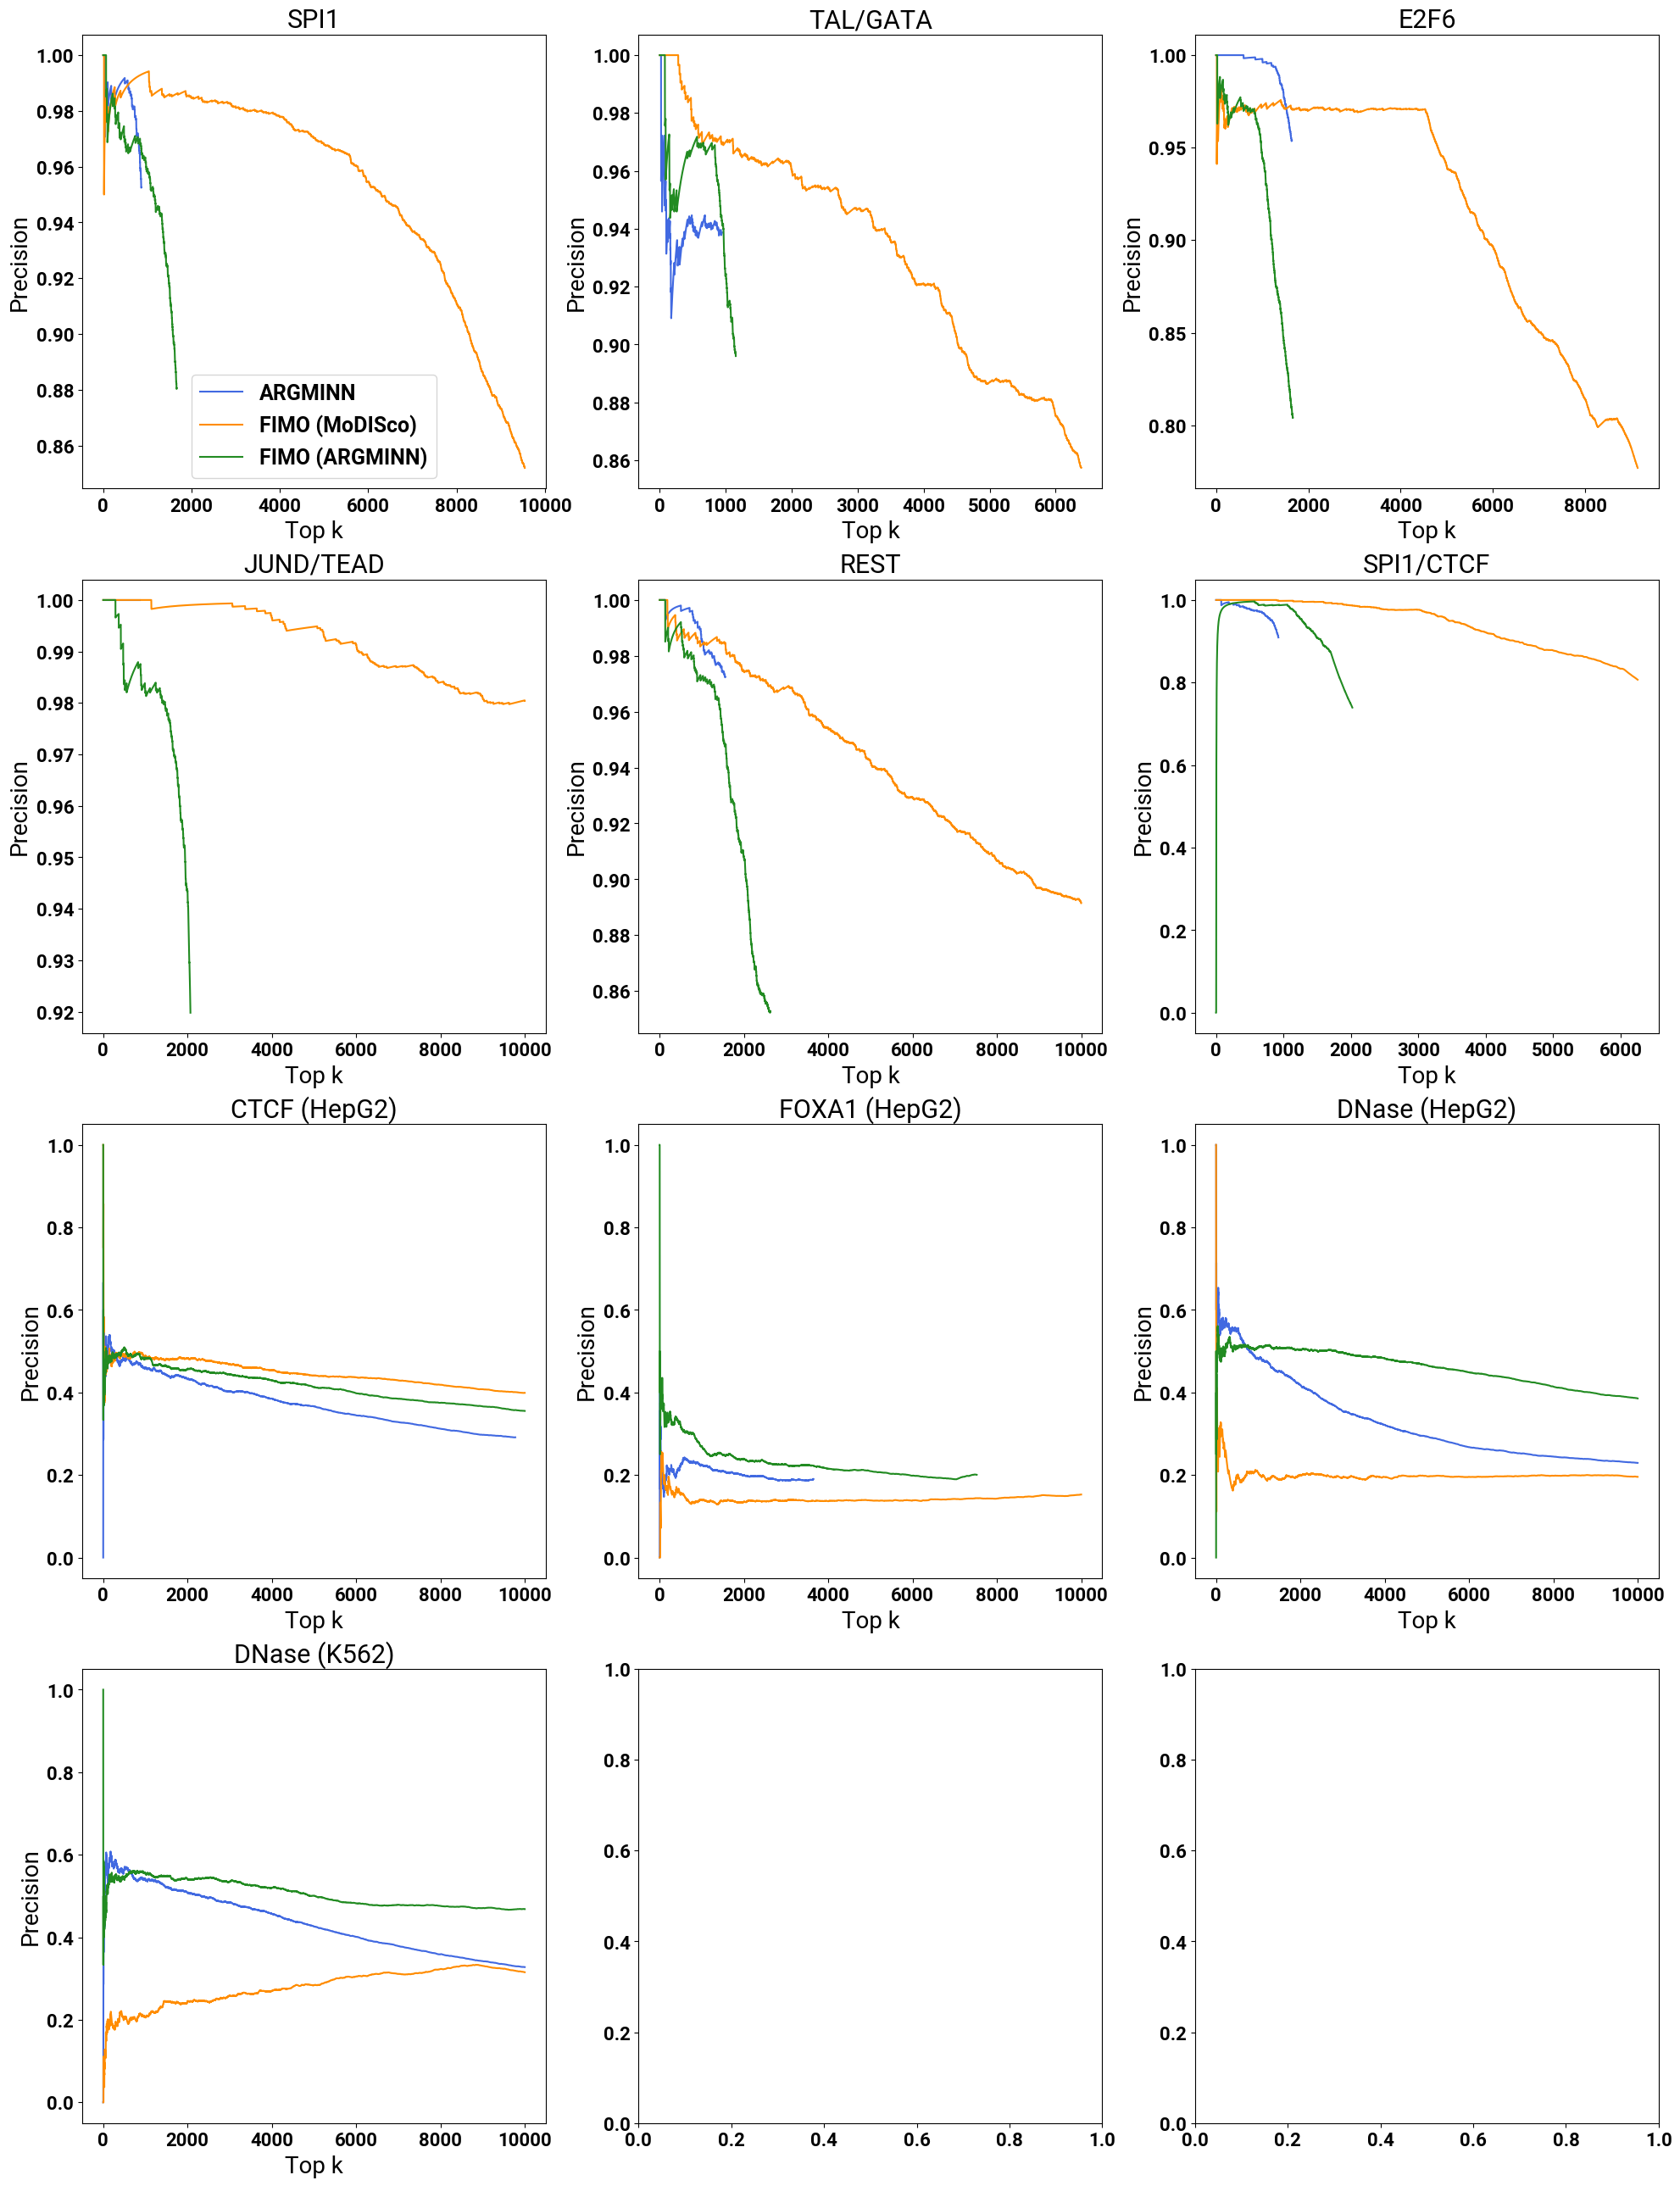

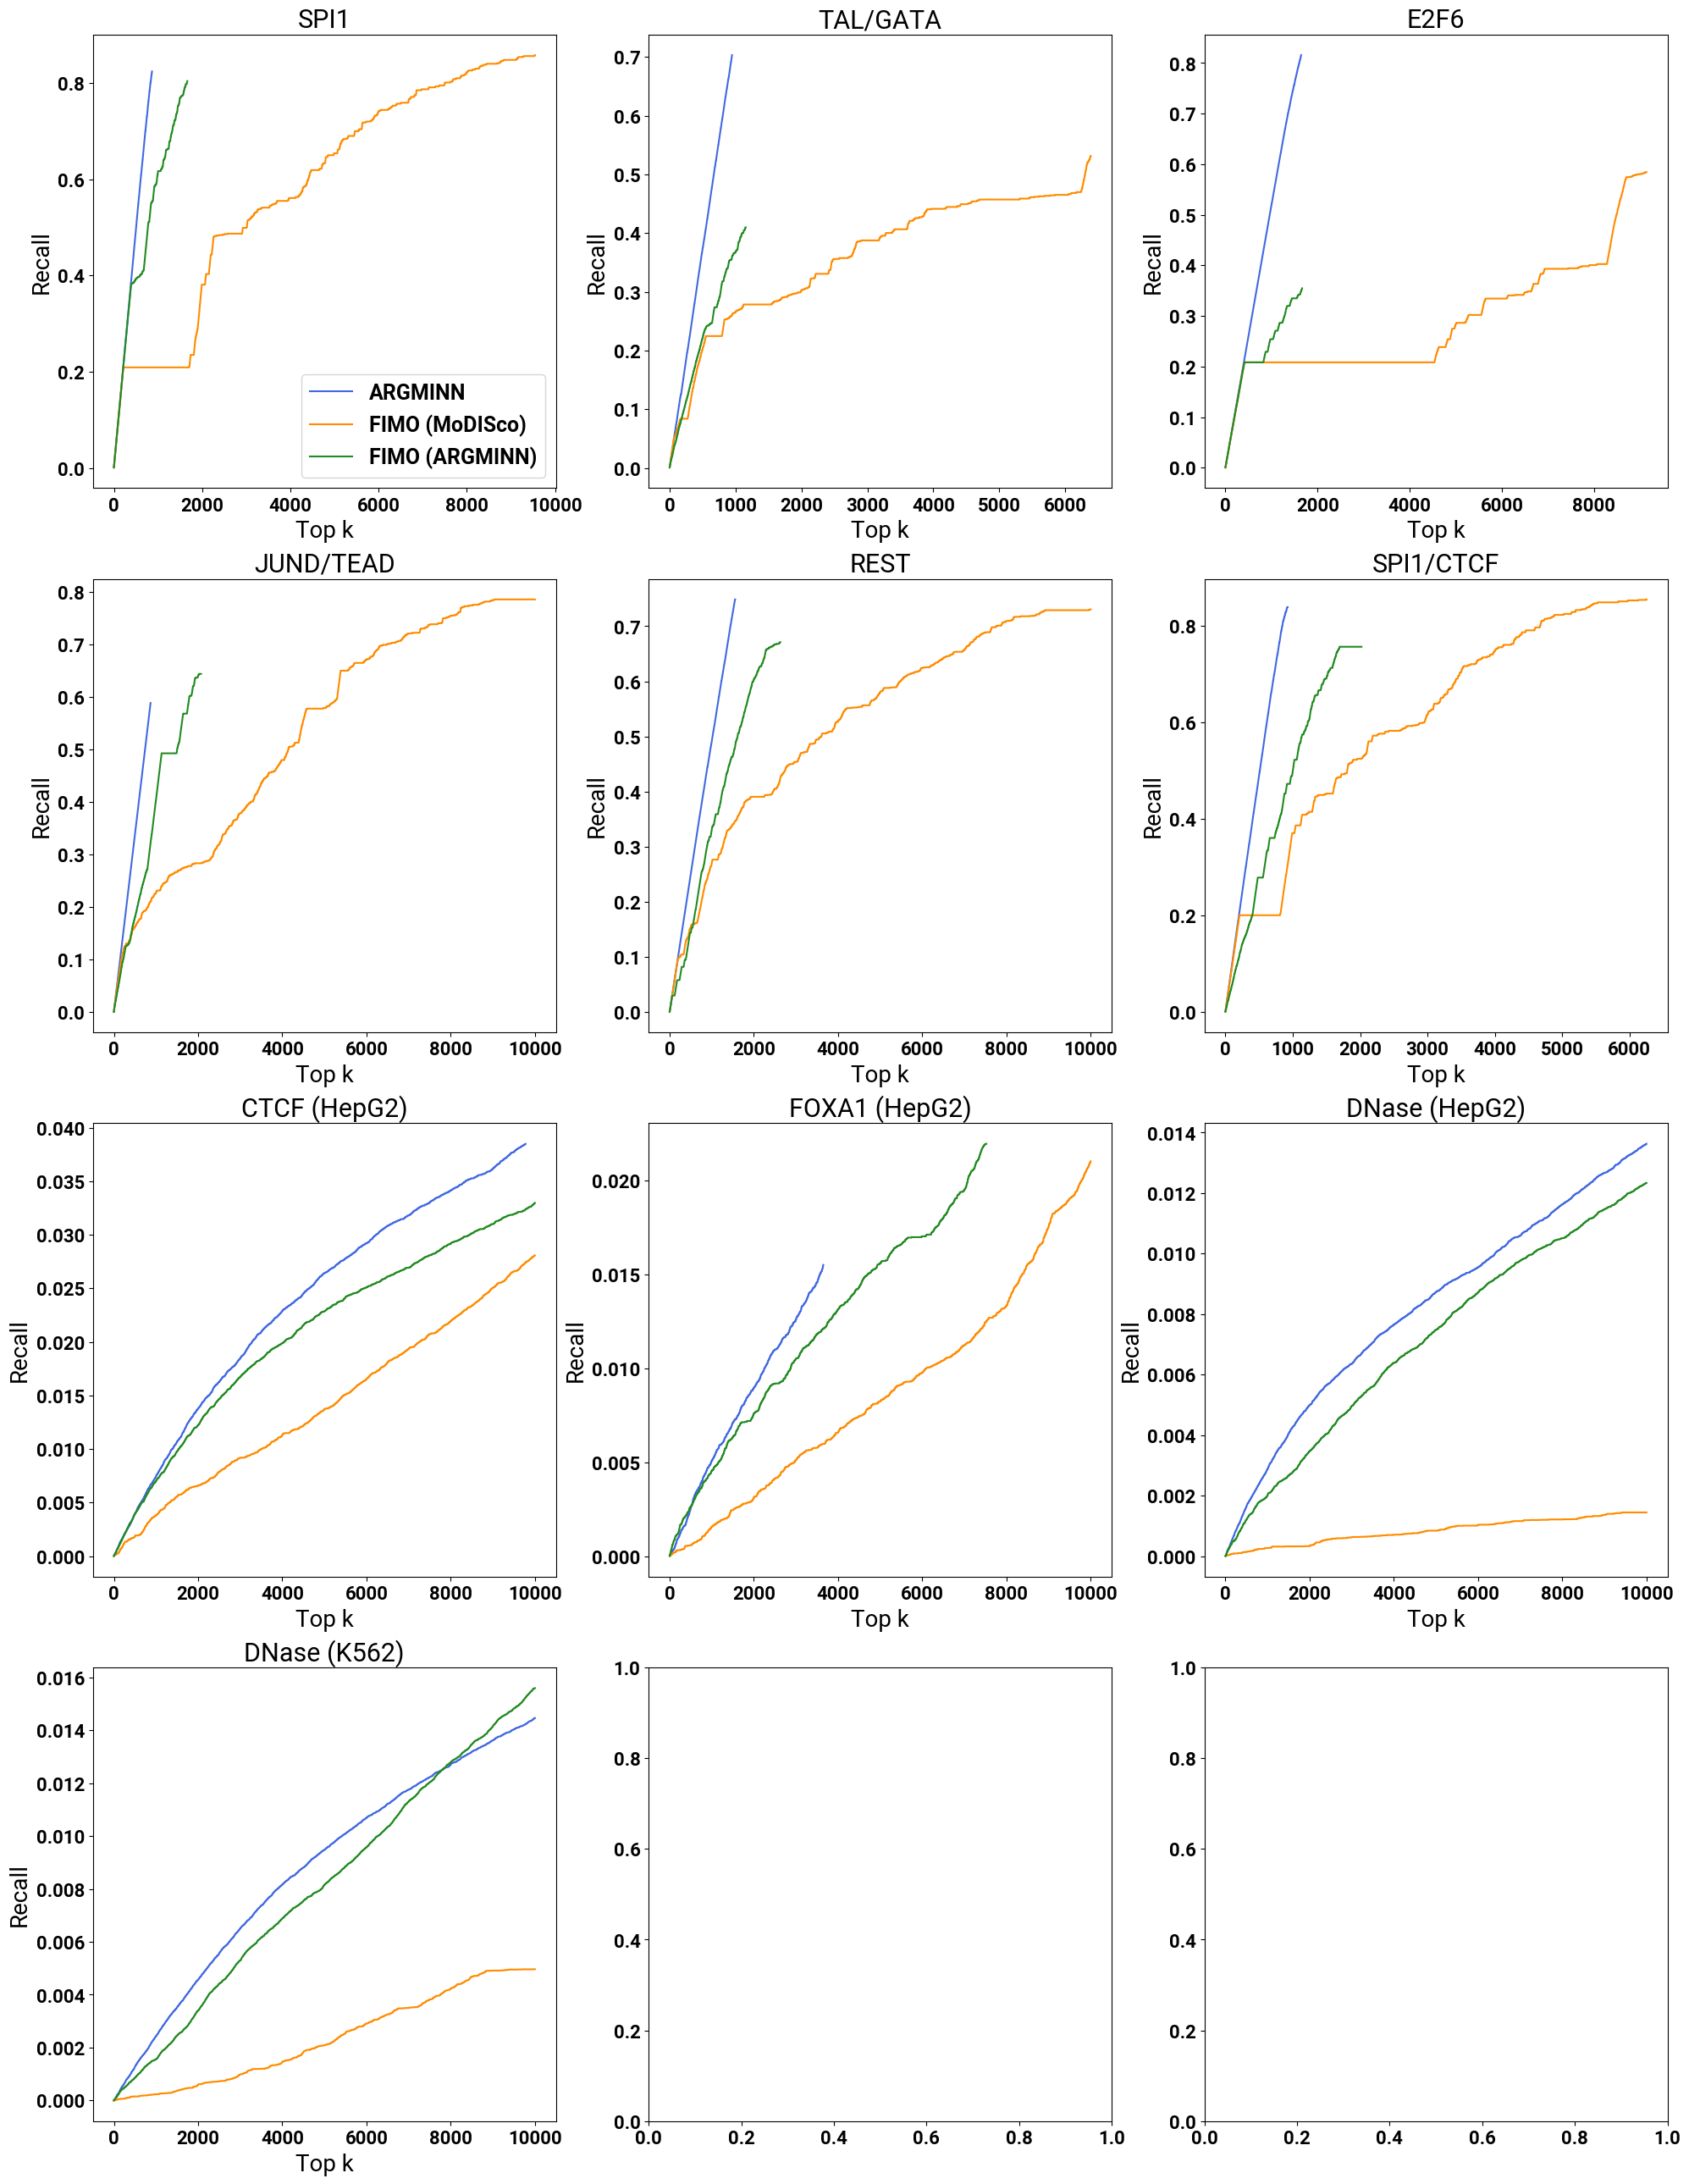

In [35]:
# Plot precision and recall separately
num_cols = 3
num_rows = int(np.ceil(len(datasets) / num_cols))

# Precision
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8 * num_cols, 8 * num_rows))
if len(ax.shape) < 2:
    ax = [ax]
for i, dataset_key in enumerate(datasets):
    row_i, col_i = i // num_cols, i % num_cols

    ax[row_i][col_i].plot(mechint_pr_topk_vals[dataset_key][0], color="royalblue", label="ARGMINN")
    ax[row_i][col_i].plot(fimo_modisco_pr_topk_vals[dataset_key][0], color="darkorange", label="FIMO (MoDISco)")
    ax[row_i][col_i].plot(fimo_mechint_pr_topk_vals[dataset_key][0], color="forestgreen", label="FIMO (ARGMINN)")
    ax[row_i][col_i].set_title(datasets[i])
    ax[row_i][col_i].set_xlabel("Top k")
    ax[row_i][col_i].set_ylabel("Precision")
ax[0][0].legend()
plt.show()
fig.savefig(os.path.join(figures_out_path, "precision.svg"), format="svg")

# Recall
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8 * num_cols, 8 * num_rows))
if len(ax.shape) < 2:
    ax = [ax]
for i, dataset_key in enumerate(datasets):
    row_i, col_i = i // num_cols, i % num_cols

    ax[row_i][col_i].plot(mechint_pr_topk_vals[dataset_key][1], color="royalblue", label="ARGMINN")
    ax[row_i][col_i].plot(fimo_modisco_pr_topk_vals[dataset_key][1], color="darkorange", label="FIMO (MoDISco)")
    ax[row_i][col_i].plot(fimo_mechint_pr_topk_vals[dataset_key][1], color="forestgreen", label="FIMO (ARGMINN)")
    ax[row_i][col_i].set_title(datasets[i])
    ax[row_i][col_i].set_xlabel("Top k")
    ax[row_i][col_i].set_ylabel("Recall")
ax[0][0].legend()
plt.show()
fig.savefig(os.path.join(figures_out_path, "recall.svg"), format="svg")

# k_limit = 2000
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8 * num_cols, 8 * num_rows))
# if len(ax.shape) < 2:
#     ax = [ax]
# for i, dataset_key in enumerate(datasets):
#     row_i, col_i = i // num_cols, i % num_cols

#     ax[row_i][col_i].plot(mechint_pr_topk_vals[dataset_key][1][:k_limit], color="royalblue", label="ARGMINN")
#     ax[row_i][col_i].plot(fimo_modisco_pr_topk_vals[dataset_key][1][:k_limit], color="darkorange", label="FIMO (MoDISco)")
#     ax[row_i][col_i].plot(fimo_mechint_pr_topk_vals[dataset_key][1][:k_limit], color="forestgreen", label="FIMO (ARGMINN)")
#     ax[row_i][col_i].set_title(datasets[i])
#     ax[row_i][col_i].set_xlabel("Top k")
#     ax[row_i][col_i].set_ylabel("Recall")
# ax[0][0].legend()

# plt.show()

In [36]:
# Compute true distribution of motif hit counts
true_num_hits_per_seq = {}
mechint_num_hits_per_seq, fimo_modisco_num_hits_per_seq, fimo_mechint_num_hits_per_seq = {}, {}, {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    true_num_hits_per_seq[dataset_key] = np.array([len(row) for row in all_true_hits[dataset_key]])
    mechint_num_hits_per_seq[dataset_key] = np.array([len(row) for row in mechint_called_hits[dataset_key]])
    fimo_modisco_num_hits_per_seq[dataset_key] = np.array([len(row) for row in fimo_modisco_called_hits[dataset_key]])
    fimo_mechint_num_hits_per_seq[dataset_key] = np.array([len(row) for row in fimo_mechint_called_hits[dataset_key]])

  0%|          | 0/10 [00:00<?, ?it/s]

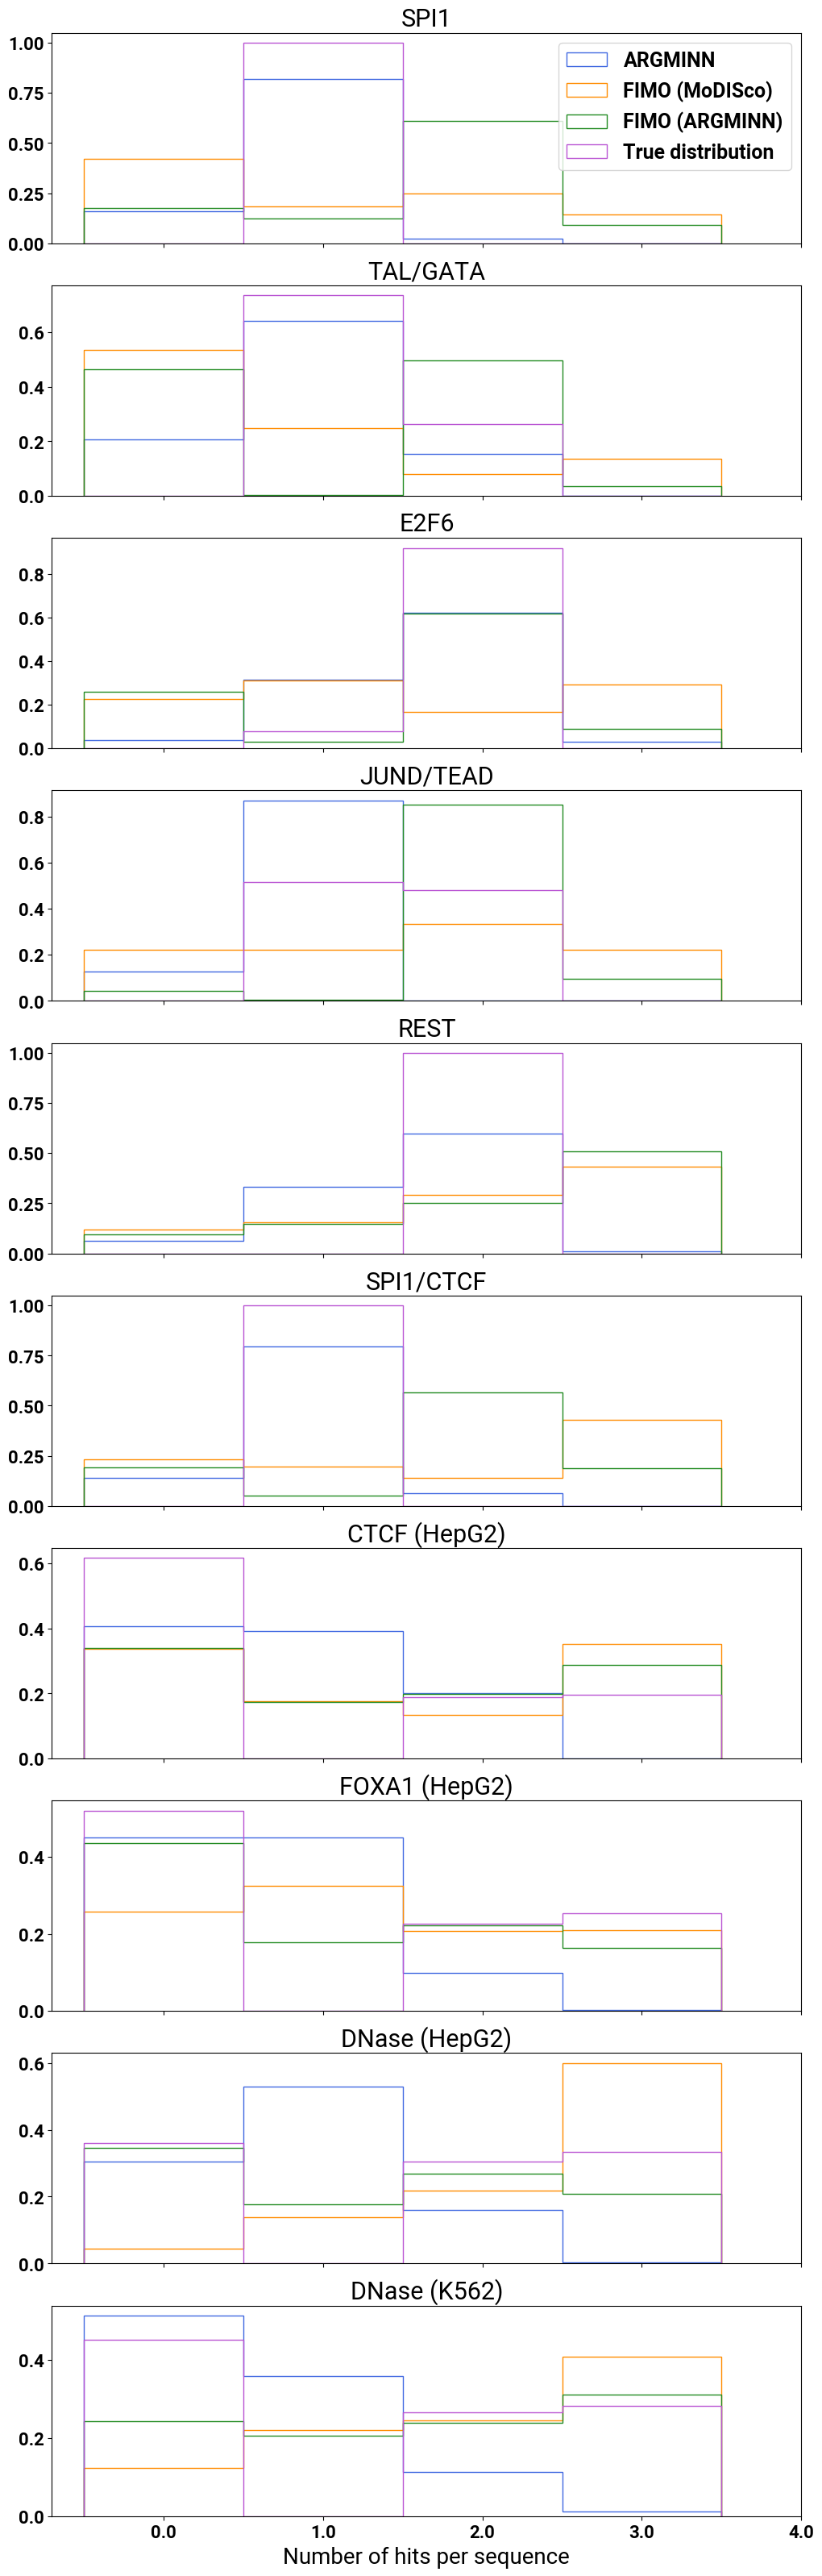

In [37]:
# Plot number of hits in each sequence from each method
fig, ax = plt.subplots(nrows=len(datasets), sharex=True, figsize=(12, 4 * len(datasets)))
bins = np.linspace(0, 4, 5)
for i, dataset_key in enumerate(datasets):
    if type(ax) is not np.ndarray:
        ax = [ax]
    ax[i].hist(
        mechint_num_hits_per_seq[dataset_key], bins=bins, color="royalblue", alpha=1,
        align="left", density=True, histtype="step", label="ARGMINN"
    )
    ax[i].hist(
        fimo_modisco_num_hits_per_seq[dataset_key], bins=bins, color="darkorange", alpha=1,
        align="left", density=True, histtype="step", label="FIMO (MoDISco)"
    )
    ax[i].hist(
        fimo_mechint_num_hits_per_seq[dataset_key], bins=bins, color="forestgreen", alpha=1,
        align="left", density=True, histtype="step", label="FIMO (ARGMINN)"
    )
    ax[i].hist(
        true_num_hits_per_seq[dataset_key], bins=bins, color="mediumorchid", alpha=1,
        align="left", density=True, histtype="step", label="True distribution"
    )
    ax[i].set_title(dataset_key)
ax[0].legend()
ax[-1].set_xticks(bins)
ax[-1].set_xticklabels(bins)
ax[-1].set_xlabel("Number of hits per sequence")
plt.show()
fig.savefig(os.path.join(figures_out_path, "hits_per_seq.svg"), format="svg")